# Climate Tool by Julia Campbell
The following code uses climate data retrieved from the Copernicus Climate Data Store API to plot modern and future climatology, find climate analogs, and compare extreme values. I am using monthly means (daily would take up too much space) and modern (ERA5) climate data and projected future (CMIP6) climate data. Usually a climatology would be data from at least ~30 years, but in this case I will use 10 years to save space. The modern data will be extracted from years 2015-2024, and the future data will be extracted from years 2090-2099. The future data will also specifically be from CESM2 and the SSP5-8.5 emissions scenario (to save space), but unfortunately it is at a lower resolution than the modern ERA5 climate data. This is the 'business-as-usual' emissions scenario. For both modern and future data, I will only use surface or near-surface data, so there will be no pressure level data involved. Finally, I chose 7 variables that are directly comparable between my two data collections (modern and future) that are interesting and useful from a climate perspective. The data will be used to plot modern vs future monthly climate data in a location of the user's choice for any of the available variables. The user will also be able to see which location on Earth currently has a climatology most similar to a given location's projected future climatology. Finally, the user will also be able to see where on Earth experiences the most extreme values of a given variable for both modern and future climate data. In the future, I plan to extend this code to potentially include other SSP scenarios, other models in the CMIP6 ensemble, data at various pressure levels, or longer time-spanned climatology, that data is all available but would take up more space. I'd also like to eventually mend the 'climate analog' function and 'extreme values' function to use all the monthly means instead of annual means. Finally, for this program to be more accurate I will need to find higher resolution future climate data available elsewhere.

In [3]:
# Make an account on the Copernicus CDS website
# Follow the API instructions
# Import necessary library and check that it works
import cdsapi
c = cdsapi.Client()
print("CDS API is working!")

2025-04-24 14:41:42,665 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-24 14:41:42,666 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


CDS API is working!


In [4]:
# Import necessary libraries
import xarray as xr
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [4]:
# Collect the monthly mean data for all 7 variables in all 10 years from the ERA5 collection (present-day climate)

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "2m_dewpoint_temperature",
        "2m_temperature",
        "surface_pressure",
        "total_precipitation",
        "10m_wind_speed",
        "mean_evaporation_rate",
        "surface_solar_radiation_downwards",
        "surface_thermal_radiation_downwards",
        "total_cloud_cover",
        "snow_depth"
    ],
    "year": [
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-17 14:05:09,007 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 14:05:09,010 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 14:05:09,900 INFO Request ID is 7564161d-8c8f-4fb1-9abc-a43fdcf617ae
2025-04-17 14:05:10,514 INFO status has been updated to accepted
2025-04-17 14:05:25,585 INFO status has been updated to running
2025-04-17 14:07:07,552 WARNING Structural differences in grib fields detected when opening in xarray. Opening the grib file safely, however this may result in files with non-intuitive filenames.
2025-04-17 14:09:32,767 INFO status has been updated to successful
                                                                                

'f1774a8e113a5eb9e9721bd659d8fc89.zip'

In [5]:
# Unzip the zipped file downloaded above
# Save the data in an 'extracted_data' folder

zip_path = "f1774a8e113a5eb9e9721bd659d8fc89.zip"  
extract_path = "extracted_data"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Check that the files are actually in the data folder

files = os.listdir(extract_path)
print("Extracted files:", files)

Files extracted to: extracted_data
Extracted files: ['data_0.nc', 'data_1.nc']


In [9]:
# Check the variables and dimensions in each netCDF file

nc_file = "extracted_data/data_1.nc"  
ds = xr.open_dataset(nc_file)

print(ds)

# 'data_0.nc' file has dimensions 'valid_time': 120, 'latitude': 721, 'longitude': 1440
# 'data_0.nc' file has float variables 'sp', 'sd', 'tcc', 't2m', 'd2m', 'si10'
# 'data_1.nc' file has dimensions 'valid_time': 120, 'latitude': 721, 'longitude': 1440
# 'data_1.nc' file has float variables 'ssrd', 'strd', 'tp', 'avg_ie'

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 120, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 960B 2015-01-01T06:00:00 ... 2024...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 2kB ...
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 498MB ...
    strd        (valid_time, latitude, longitude) float32 498MB ...
    tp          (valid_time, latitude, longitude) float32 498MB ...
    avg_ie      (valid_time, latitude, longitude) float32 498MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts


In [10]:
# Collect the monthly mean data for all 7 variables in all 10 years from the CMIP6 collection (projected future climate)
# Specifically choosing CESM2 data for the SSP5-8.5 scenario
# This data collection requires me to download each variable separately

# Downloading near-surface air temperature

dataset = "projections-cmip6"
request = {
    "temporal_resolution": "monthly",
    "experiment": "ssp5_8_5",
    "variable": "near_surface_air_temperature",
    "model": "cesm2",
    "year": [
        "2090", "2091", "2092",
        "2093", "2094", "2095",
        "2096", "2097", "2098",
        "2099"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-17 14:38:26,361 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 14:38:26,362 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 14:38:27,380 INFO Request ID is 1aa2b8a2-b37c-40ff-a05b-5977d56a7420
2025-04-17 14:38:27,559 INFO status has been updated to accepted
2025-04-17 14:39:01,126 INFO status has been updated to successful
                                                                                

'e6f70a14541937bb0028a600e1183c16.zip'

In [13]:
# Unzip the zipped file downloaded above
# Save the data in an 'extracted_data' folder

zip_path = "e6f70a14541937bb0028a600e1183c16.zip"  
extract_path = "extracted_data"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Check that the files are actually in the data folder

files = os.listdir(extract_path)
print("Extracted files:", files)

Files extracted to: extracted_data
Extracted files: ['provenance.json', 'tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_0.nc', 'data_1.nc', 'provenance.png']


In [14]:
# Check the variables and dimensions in each netCDF file

nc_file = "extracted_data/tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc"  
ds = xr.open_dataset(nc_file)

print(ds)

# 'tas...nc' file has dimensions 'time': 120, 'lat': 192, 'lon': 288, 'nbnd': 2
# 'tas...nc' file has float variables 'tas', 'time_bnds', 'lat_bnds', 'lon_bnds'

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 120, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 960B 2090-01-15 12:00:00 ... 2099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 27MB ...
    time_bnds  (time, nbnd) object 2kB ...
    lat_bnds   (lat, nbnd) float64 3kB ...
    lon_bnds   (lon, nbnd) float64 5kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1735
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/6aa12f5a-cf48-42af-acb0-f54b5afa0f41
    variab

In [15]:
# Downloading snow depth

dataset = "projections-cmip6"
request = {
    "temporal_resolution": "monthly",
    "experiment": "ssp5_8_5",
    "variable": "snow_depth",
    "model": "cesm2",
    "year": [
        "2090", "2091", "2092",
        "2093", "2094", "2095",
        "2096", "2097", "2098",
        "2099"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-17 14:49:16,085 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 14:49:16,086 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 14:49:17,748 INFO Request ID is 9294c6a9-8ba6-4daf-ad74-24ba6ab2ebc9
2025-04-17 14:49:18,105 INFO status has been updated to accepted
2025-04-17 14:49:40,067 INFO status has been updated to running
2025-04-17 14:50:08,924 INFO status has been updated to successful
                                                                                

'43da3f3fa3ff1de36714bccf8b46e68f.zip'

In [16]:
# Unzip the zipped file downloaded above
# Save the data in an 'extracted_data' folder

zip_path = "43da3f3fa3ff1de36714bccf8b46e68f.zip"  
extract_path = "extracted_data"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Check that the files are actually in the data folder

files = os.listdir(extract_path)
print("Extracted files:", files)

Files extracted to: extracted_data
Extracted files: ['provenance.json', 'tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_0.nc', 'data_1.nc', 'provenance.png', 'snd_LImon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc']


In [17]:
# Check the variables and dimensions in each netCDF file

nc_file = "extracted_data/snd_LImon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc"  
ds = xr.open_dataset(nc_file)

print(ds)

# 'snd...nc' file has dimensions 'time': 120, 'lat': 192, 'lon': 288, 'hist_interval': 2
# 'snd...nc' file has float variables 'snd', 'time_bnds', 'lat_bnds', 'lon_bnds'

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 120, lat: 192, lon: 288, hist_interval: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 960B 2090-01-15 12:00:00 ... 2099-12-15 12:00:00
Dimensions without coordinates: hist_interval
Data variables:
    snd        (time, lat, lon) float32 27MB ...
    time_bnds  (time, hist_interval) object 2kB ...
    lat_bnds   (lat, hist_interval) float32 2kB ...
    lon_bnds   (lon, hist_interval) float32 2kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1735
    ...                     ...
    sub_experiment_id:      none
    table_id:               LImon
    tracking_id:            hdl:21.14100/d

In [18]:
# Downloading precipitation

dataset = "projections-cmip6"
request = {
    "temporal_resolution": "monthly",
    "experiment": "ssp5_8_5",
    "variable": "precipitation",
    "model": "cesm2",
    "year": [
        "2090", "2091", "2092",
        "2093", "2094", "2095",
        "2096", "2097", "2098",
        "2099"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-17 14:51:52,940 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 14:51:52,942 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 14:51:53,912 INFO Request ID is dcda193b-7bf9-4c07-a252-56c882e0f8e7
2025-04-17 14:51:54,627 INFO status has been updated to accepted
2025-04-17 14:52:16,655 INFO status has been updated to running
2025-04-17 14:52:28,215 INFO status has been updated to successful
                                                                                

'b297521f4e9e85057e6b943879edfdb1.zip'

In [19]:
# Unzip the zipped file downloaded above
# Save the data in an 'extracted_data' folder

zip_path = "b297521f4e9e85057e6b943879edfdb1.zip"  
extract_path = "extracted_data"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Check that the files are actually in the data folder

files = os.listdir(extract_path)
print("Extracted files:", files)

Files extracted to: extracted_data
Extracted files: ['provenance.json', 'tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_0.nc', 'data_1.nc', 'pr_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'provenance.png', 'snd_LImon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc']


In [20]:
# Check the variables and dimensions in each netCDF file

nc_file = "extracted_data/pr_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc"  
ds = xr.open_dataset(nc_file)

print(ds)

# 'pr...nc' file has dimensions 'time': 120, 'lat': 192, 'lon': 288, 'nbnd': 2
# 'pr...nc' file has float variables 'pr', 'time_bnds', 'lat_bnds', 'lon_bnds'

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 120, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 960B 2090-01-15 12:00:00 ... 2099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    pr         (time, lat, lon) float32 27MB ...
    time_bnds  (time, nbnd) object 2kB ...
    lat_bnds   (lat, nbnd) float64 3kB ...
    lon_bnds   (lon, nbnd) float64 5kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1735
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/af147846-667d-479d-a02c-c03009ea1ba9
    variab

In [21]:
# Downloading surface air pressure

dataset = "projections-cmip6"
request = {
    "temporal_resolution": "monthly",
    "experiment": "ssp5_8_5",
    "variable": "surface_air_pressure",
    "model": "cesm2",
    "year": [
        "2090", "2091", "2092",
        "2093", "2094", "2095",
        "2096", "2097", "2098",
        "2099"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-17 14:54:09,075 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 14:54:09,076 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 14:54:10,214 INFO Request ID is cbf24f34-0389-49b4-8758-a2e39c9877f8
2025-04-17 14:54:10,421 INFO status has been updated to accepted
2025-04-17 14:54:19,333 INFO status has been updated to running
2025-04-17 14:55:01,466 INFO status has been updated to successful
                                                                                

'1cb33e04fdf1307e8d4c315d1a9710c2.zip'

In [22]:
# Unzip the zipped file downloaded above
# Save the data in an 'extracted_data' folder

zip_path = "1cb33e04fdf1307e8d4c315d1a9710c2.zip"  
extract_path = "extracted_data"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Check that the files are actually in the data folder

files = os.listdir(extract_path)
print("Extracted files:", files)

Files extracted to: extracted_data
Extracted files: ['provenance.json', 'ps_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_0.nc', 'data_1.nc', 'pr_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'provenance.png', 'snd_LImon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc']


In [23]:
# Check the variables and dimensions in each netCDF file

nc_file = "extracted_data/ps_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc"  
ds = xr.open_dataset(nc_file)

print(ds)

# 'ps...nc' file has dimensions 'time': 120, 'lat': 192, 'lon': 288, 'nbnd': 2
# 'ps...nc' file has float variables 'ps', 'time_bnds', 'lat_bnds', 'lon_bnds'

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 120, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 960B 2090-01-15 12:00:00 ... 2099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    ps         (time, lat, lon) float32 27MB ...
    time_bnds  (time, nbnd) object 2kB ...
    lat_bnds   (lat, nbnd) float64 3kB ...
    lon_bnds   (lon, nbnd) float64 5kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1735
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/599ce2cf-d3d3-4fb9-b2e4-66fd0960ceae
    variab

In [24]:
# Downloading total cloud cover percentage

dataset = "projections-cmip6"
request = {
    "temporal_resolution": "monthly",
    "experiment": "ssp5_8_5",
    "variable": "total_cloud_cover_percentage",
    "model": "cesm2",
    "year": [
        "2090", "2091", "2092",
        "2093", "2094", "2095",
        "2096", "2097", "2098",
        "2099"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-17 14:56:34,136 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 14:56:34,138 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 14:56:36,033 INFO Request ID is ac3a4664-3b95-4ca5-9b6a-26899f22034c
2025-04-17 14:56:36,214 INFO status has been updated to accepted
2025-04-17 14:56:50,579 INFO status has been updated to running
2025-04-17 14:57:10,140 INFO status has been updated to successful
                                                                                

'c5aa6b4db23bce643c224beea0c7b4ed.zip'

In [25]:
# Unzip the zipped file downloaded above
# Save the data in an 'extracted_data' folder

zip_path = "c5aa6b4db23bce643c224beea0c7b4ed.zip"  
extract_path = "extracted_data"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Check that the files are actually in the data folder

files = os.listdir(extract_path)
print("Extracted files:", files)

Files extracted to: extracted_data
Extracted files: ['provenance.json', 'ps_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_0.nc', 'clt_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_1.nc', 'pr_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'provenance.png', 'snd_LImon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc']


In [26]:
# Check the variables and dimensions in each netCDF file

nc_file = "extracted_data/clt_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc"  
ds = xr.open_dataset(nc_file)

print(ds)

# 'clt...nc' file has dimensions 'time': 120, 'lat': 192, 'lon': 288, 'nbnd': 2
# 'clt...nc' file has float variables 'clt', 'time_bnds', 'lat_bnds', 'lon_bnds'

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 120, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 960B 2090-01-15 12:00:00 ... 2099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    clt        (time, lat, lon) float32 27MB ...
    time_bnds  (time, nbnd) object 2kB ...
    lat_bnds   (lat, nbnd) float64 3kB ...
    lon_bnds   (lon, nbnd) float64 5kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1735
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/0ff8c5f2-e12a-42db-8965-4be658ed2596
    variab

In [33]:
# Downloading near-surface specific humidity

dataset = "projections-cmip6"
request = {
    "temporal_resolution": "monthly",
    "experiment": "ssp5_8_5",
    "variable": "near_surface_specific_humidity",
    "model": "cesm2",
    "year": [
        "2090", "2091", "2092",
        "2093", "2094", "2095",
        "2096", "2097", "2098",
        "2099"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-17 15:03:45,636 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 15:03:45,638 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 15:03:46,904 INFO Request ID is a8bf0aab-0fd0-4ca9-8e01-34e573dbf32d
2025-04-17 15:03:47,098 INFO status has been updated to accepted
2025-04-17 15:04:01,389 INFO status has been updated to running
2025-04-17 15:04:20,736 INFO status has been updated to successful
                                                                                

'a851bc27caccb7975067153fe81a627b.zip'

In [34]:
# Unzip the zipped file downloaded above
# Save the data in an 'extracted_data' folder

zip_path = "a851bc27caccb7975067153fe81a627b.zip"  
extract_path = "extracted_data"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Check that the files are actually in the data folder

files = os.listdir(extract_path)
print("Extracted files:", files)

Files extracted to: extracted_data
Extracted files: ['huss_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'provenance.json', 'ps_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_0.nc', 'rsds_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'clt_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_1.nc', 'rlds_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'pr_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'provenance.png', 'snd_LImon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc']


In [35]:
# Check the variables and dimensions in each netCDF file

nc_file = "extracted_data/huss_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc"  
ds = xr.open_dataset(nc_file)

print(ds)

# 'huss...nc' file has dimensions 'time': 120, 'lat': 192, 'lon': 288, 'nbnd': 2
# 'huss...nc' file has float variables 'huss', 'time_bnds', 'lat_bnds', 'lon_bnds'

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 120, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 960B 2090-01-15 12:00:00 ... 2099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    huss       (time, lat, lon) float32 27MB ...
    time_bnds  (time, nbnd) object 2kB ...
    lat_bnds   (lat, nbnd) float64 3kB ...
    lon_bnds   (lon, nbnd) float64 5kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1735
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/d0e3ec08-2f60-4a5e-b4ff-d3b5dd74004d
    variab

In [36]:
# Downloading near-surface wind speed

dataset = "projections-cmip6"
request = {
    "temporal_resolution": "monthly",
    "experiment": "ssp5_8_5",
    "variable": "near_surface_wind_speed",
    "model": "cesm2",
    "year": [
        "2090", "2091", "2092",
        "2093", "2094", "2095",
        "2096", "2097", "2098",
        "2099"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-04-17 15:06:35,873 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 15:06:35,875 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 15:06:36,791 INFO Request ID is 190cdb87-079d-4357-99ef-87c871808363
2025-04-17 15:06:36,994 INFO status has been updated to accepted
2025-04-17 15:06:51,346 INFO status has been updated to running
2025-04-17 15:07:10,749 INFO status has been updated to successful
                                                                                

'24c0fba0f0dd5aaf05e52bc9f82e6527.zip'

In [37]:
# Unzip the zipped file downloaded above
# Save the data in an 'extracted_data' folder

zip_path = "24c0fba0f0dd5aaf05e52bc9f82e6527.zip"  
extract_path = "extracted_data"  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

# Check that the files are actually in the data folder

files = os.listdir(extract_path)
print("Extracted files:", files)

Files extracted to: extracted_data
Extracted files: ['huss_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'provenance.json', 'ps_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_0.nc', 'rsds_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'clt_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'data_1.nc', 'rlds_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'sfcWind_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'pr_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc', 'provenance.png', 'snd_LImon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc']


In [38]:
# Check the variables and dimensions in each netCDF file

nc_file = "extracted_data/sfcWind_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc"  
ds = xr.open_dataset(nc_file)

print(ds)

# 'sfcWind...nc' file has dimensions 'time': 120, 'lat': 192, 'lon': 288, 'nbnd': 2
# 'sfcWind...nc' file has float variables 'sfcWind', 'time_bnds', 'lat_bnds', 'lon_bnds'

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 120, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) object 960B 2090-01-15 12:00:00 ... 2099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    sfcWind    (time, lat, lon) float32 27MB ...
    time_bnds  (time, nbnd) object 2kB ...
    lat_bnds   (lat, nbnd) float64 3kB ...
    lon_bnds   (lon, nbnd) float64 5kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   735110.0
    branch_time_in_parent:  735110.0
    case_id:                1735
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/5fff8597-9c64-4233-8a87-21787c0fe72f
    variab

In [5]:
# Save each variable separately with a descriptive name

# Saving the modern climate variables 

file_mod_data0 = xr.open_dataset('extracted_data/data_0.nc') # file with some variables
mod_ps = file_mod_data0.sp # surface pressure (Pa)
mod_snow = file_mod_data0.sd # snow depth (m of water equivalent)
mod_cloud = file_mod_data0.tcc # total cloud cover (fraction)
mod_temp = file_mod_data0.t2m # air temperature at 2m (K)
mod_dewtemp = file_mod_data0.d2m # dewpoint temperature at 2m (K), used for specific humidity calculation
mod_wind = file_mod_data0.si10 # wind speed at 10m (m/s)

file_mod_data1 = xr.open_dataset('extracted_data/data_1.nc') # file with precipitation
mod_pr = file_mod_data1.tp # total precipitation (m)

# Saving the future climate variables

file_fut_ps = xr.open_dataset('extracted_data/ps_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc')
fut_ps = file_fut_ps.ps # surface air pressure (Pa)

file_fut_snow = xr.open_dataset('extracted_data/snd_LImon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc')
fut_snow = file_fut_snow.snd # snow depth (m)

file_fut_cloud = xr.open_dataset('extracted_data/clt_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc')
fut_cloud = file_fut_cloud.clt # total cloud cover (%)

file_fut_temp = xr.open_dataset('extracted_data/tas_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc')
fut_temp = file_fut_temp.tas # near-surface air temperature (K)

file_fut_sh = xr.open_dataset('extracted_data/huss_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc')
fut_sh = file_fut_sh.huss # near-surface specific humidity (kg/kg)

file_fut_wind = xr.open_dataset('extracted_data/sfcWind_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc')
fut_wind = file_fut_wind.sfcWind # near-surface wind speed (m/s)

file_fut_pr = xr.open_dataset('extracted_data/pr_Amon_CESM2_ssp585_r4i1p1f1_gn_20900115-20991215.nc')
fut_pr = file_fut_pr.pr # precipitation (mm/s)

In [6]:
# Now I want to get monthly climatologies so that it's 12 time values, not 120 time values
# Modern monthly climatologies

mod_monthly_pspa = mod_ps.groupby("valid_time.month").mean("valid_time")
mod_monthly_sno = mod_snow.groupby("valid_time.month").mean("valid_time")
mod_monthly_cloud = mod_cloud.groupby("valid_time.month").mean("valid_time")
mod_monthly_temp = mod_temp.groupby("valid_time.month").mean("valid_time")
mod_monthly_dewtemp = mod_dewtemp.groupby("valid_time.month").mean("valid_time")
mod_monthly_wind = mod_wind.groupby("valid_time.month").mean("valid_time")
mod_monthly_pr = mod_pr.groupby("valid_time.month").mean("valid_time")

In [7]:
# Future monthly climatologies

fut_monthly_pspa = fut_ps.groupby("time.month").mean("time")
fut_monthly_sno = fut_snow.groupby("time.month").mean("time")
fut_monthly_clouds = fut_cloud.groupby("time.month").mean("time")
fut_monthly_temp = fut_temp.groupby("time.month").mean("time")
fut_monthly_sh = fut_sh.groupby("time.month").mean("time")
fut_monthly_wind = fut_wind.groupby("time.month").mean("time")
fut_monthly_pr = fut_pr.groupby("time.month").mean("time")

In [8]:
# Now I need all my units to line up for my modern and future variables
# Ps is in Pa for both but I want hPa, so convert for both
mod_monthly_ps = mod_monthly_pspa / 100
fut_monthly_ps = fut_monthly_pspa / 100
# Snow is in m depth for both but I want cm, so convert for both
mod_monthly_snow = mod_monthly_sno * 100
fut_monthly_snow = fut_monthly_sno * 100
# Cloud is in a fraction for modern and percentage for future, so convert the fraction to a percent
mod_monthly_clouds = mod_monthly_cloud * 100 
# Temp is in Kelvin for both but I want Celsius, so convert for both
mod_monthly_temps = mod_monthly_temp - 273.15
fut_monthly_temps = fut_monthly_temp - 273.15
# Wind is in m/s for both
# Precipitation is in mm/s for future and m for modern
fut_monthly_precip = fut_monthly_pr * 86400 * 365 # convert future from mm/s to mm/yr
seconds_per_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) * 24 * 60 * 60  
mod_monthly_prec = (mod_monthly_pr * 10000) / seconds_per_month[:, np.newaxis, np.newaxis] # convert from m to mm/s
mod_monthly_precip = mod_monthly_prec * 86400 * 365 # convert from mm/s to mm/yr

In [9]:
# specific humidity requires a calculation

def dewpoint_to_specific_humidity(Td, P):
    """
    Td: Dewpoint temperature (K)
    P: Surface pressure (hPa)
    Returns: specific humidity (kg/kg)
    """
    # Convert Td to Celsius
    Td_C = Td - 273.15
    
    # Tetens formula for vapor pressure (hPa)
    es = 6.112 * np.exp((17.67 * Td_C) / (Td_C + 243.5))
    
    # Compute specific humidity
    q = (0.622 * es) / (P - (1 - 0.622) * es)
    return q

mod_monthly_sh = dewpoint_to_specific_humidity(mod_monthly_dewtemp, mod_monthly_ps) # use modern ps and dewpoint temp to find sh

In [10]:
# convert specific humidity (kg/kg) to g of water vapor per kg of air
mod_monthly_spechum = mod_monthly_sh * 1000
fut_monthly_spechum = fut_monthly_sh * 1000

In [11]:
# All variable units line up now
# Extract lats and lons to use in functions
mod_lats = file_mod_data0['latitude'].values  
mod_lons = file_mod_data0['longitude'].values
fut_lats = file_fut_ps['lat'].values
fut_lons = file_fut_ps['lon'].values

In [12]:
# Define proper names here for future plotting and summary table

pretty_var_names = {
    "temps": "Temperature",
    "spechum": "Specific Humidity",
    "precip": "Precipitation",
    "snow": "Snow Depth",
    "wind": "Wind Speed",
    "clouds": "Cloud Cover",
    "ps": "Surface Pressure"
}

var_units_dict = {
    "temps": "°C",
    "ps": "hPa",
    "snow": "cm",
    "clouds": "%",
    "spechum": "g/kg",
    "wind": "m/s",
    "precip": "mm/yr"
}

In [13]:
def plot_variable_climatology():
    '''
    This function will plot the monthly means of the modern and future climatology of a chosen variable 
    at a chosen location, given by the user. The user can then see the differences between modern climate
    and the 'business-as-usual' emissions scenario climate for 2090-2099.
    '''
    # Get variable name (they need to enter it exactly as I named the variables)
    var_name = input("Enter a variable name (choose one: ps, snow, clouds, temps, spechum, wind, precip): ").strip().lower()

    # Build full variable names
    mod_var_name = f"mod_monthly_{var_name}"
    fut_var_name = f"fut_monthly_{var_name}"

    # Check if variables exist
    if mod_var_name not in globals() or fut_var_name not in globals():
        print(f"Variable '{var_name}' not found.")
        return

    # Replace variable names for tital and y-axis
    var_fullname = pretty_var_names.get(var_name, var_name.capitalize())
    var_units = var_units_dict.get(var_name, '')

    # Load the data arrays
    mod_data = globals()[mod_var_name]  # shape (12, 721, 1440)
    fut_data = globals()[fut_var_name]  # shape (12, 192, 288) because lower resolution

    # Load corresponding lat/lon arrays 
    try:
        mod_lats, mod_lons = globals()['mod_lats'], globals()['mod_lons']
        fut_lats, fut_lons = globals()['fut_lats'], globals()['fut_lons']
    except KeyError:
        print("Latitude/longitude arrays not found.")
        return

    # Prompt for lat/lon input from user
    try:
        user_lat = float(input("Enter a latitude (-90 to 90): "))
        user_lon = float(input("Enter a longitude (0 to 360): "))
    except ValueError:
        print("Invalid numeric input for latitude or longitude.")
        return

    # Validate range
    if not (-90 <= user_lat <= 90) or not (0 <= user_lon <= 360):
        print("Latitude must be between -90 and 90; longitude must be between 0 and 360.")
        return

    # Find nearest lat/lon indices
    mod_lat_idx = np.abs(mod_lats - user_lat).argmin()
    mod_lon_idx = np.abs(mod_lons - user_lon).argmin()
    fut_lat_idx = np.abs(fut_lats - user_lat).argmin()
    fut_lon_idx = np.abs(fut_lons - user_lon).argmin()

    # Extract monthly time series
    mod_series = mod_data[:, mod_lat_idx, mod_lon_idx]
    fut_series = fut_data[:, fut_lat_idx, fut_lon_idx]

    # Plotting the monthly means
    months = np.arange(1, 13)
    plt.figure(figsize=(8, 5))
    plt.plot(months, mod_series, label="Modern", marker='o', color='dodgerblue')
    plt.plot(months, fut_series, label="Future", marker='o', color='mediumvioletred')
    plt.title(f"{var_fullname} Climatology at ({user_lat:.2f}°, {user_lon:.2f}°)")
    plt.xlabel("Month")
    plt.ylabel(f"{var_fullname} ({var_units})" if var_units else var_fullname)
    plt.xticks(months)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Enter a variable name (choose one: ps, snow, clouds, temps, spechum, wind, precip):  precip
Enter a latitude (-90 to 90):  40
Enter a longitude (0 to 360):  285


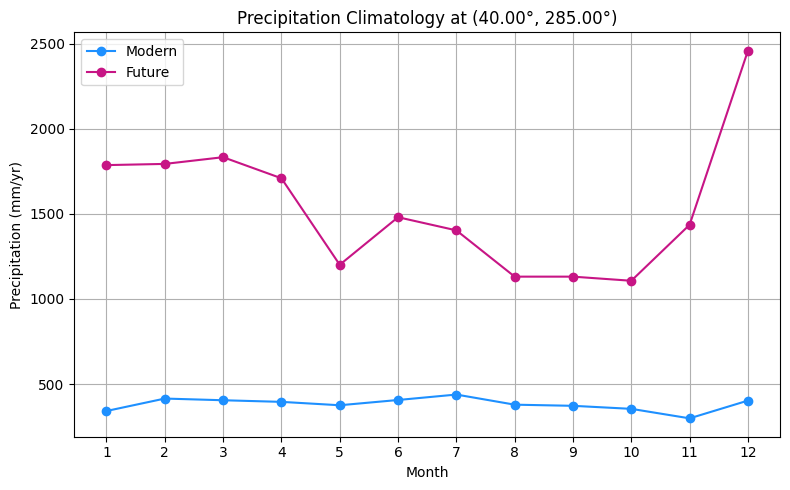

In [30]:
plot_variable_climatology()

In [16]:
# Now prepare the conectivity analysis function
# Find annual means here for use in function

# List variable suffixes here:
variable_names = ["ps", "snow", "clouds", "temps", "spechum", "wind", "precip"] 

# Initialize dictionaries for annual means
mod_data_raw = {}
fut_data_raw = {}

# Loop over each variable and compute annual means
for var in variable_names:
    mod_var = globals()[f"mod_monthly_{var}"]
    fut_var = globals()[f"fut_monthly_{var}"]
    
    # Compute the mean over the month dimension
    mod_data_raw[var] = mod_var.mean(dim='month')  
    fut_data_raw[var] = fut_var.mean(dim='month')  

In [17]:
# Create normalized versions of your data dictionaries

mod_data_norm = {}
fut_data_norm = {}

for var in mod_data_raw:
    mod_array = mod_data_raw[var]
    fut_array = fut_data_raw[var]

    # Combine modern and future arrays to normalize across both datasets
    combined = np.concatenate([mod_array.values.flatten(), fut_array.values.flatten()])
    mean = combined.mean()
    std = combined.std()

    # Apply standard normalization: (x - mean) / std
    mod_data_norm[var] = (mod_array - mean) / std
    fut_data_norm[var] = (fut_array - mean) / std

In [18]:
# Define variable weights (can be adjusted based on importance to adaptation/mitigation)
# I don't think I want snow to come into play for the climate analog function

variable_weights = {
    'temps': 3.0,     # Temperature is often the primary driver of climate impacts
    'precip': 2.5,    # Precipitation affects agriculture, water supply, etc.
    'wind': 1.0,      # Wind can matter for energy and evapotranspiration
    'spechum': 1.0,   # Specific humidity affects heat stress and evapotranspiration
    'ps': 1.0,        # Surface pressure — maybe less critical, depends on your application
    'clouds': 0.5     # Cloud cover has more indirect effects, so lower weight
}

In [19]:
def plot_locations(user_lat, user_lon, best_lat, best_lon):
    '''
    This will create a world map that will plot the user-input location,
    as well as the output climate analog location,
    so that the user can see how far they might be from one another.
    '''
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360

    user_lon_plot = convert_lon(user_lon)
    best_lon_plot = convert_lon(best_lon)

    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.stock_img()

    # Future location (input)
    ax.plot(user_lon_plot, user_lat, 'bo', markersize=8, label='Input location (projected future climate)')

    # Closest modern climate
    ax.plot(best_lon_plot, best_lat, 'o', color='hotpink', markersize=8, label='Output location (modern climate analog)')

    ax.legend(loc='lower left')
    plt.title('Climate Analog Comparison')
    plt.show()

In [20]:
def find_climate_analog(mod_data_norm, fut_data_norm, mod_data_raw, fut_data_raw, mod_lats, mod_lons, fut_lats, fut_lons):
    '''
    This is the main connectivity analysis. This function takes a user-input location,
    finds the nearest grid point with data, then looks at the normalized projected future 
    data for that location. Then, using the normalized modern climate data,
    the function finds the location on Earth with a climate most similar to the
    projected future climate of the user-input location using Euclidean distance. 
    Then, the function shows the raw annual means for each variable at each location 
    so the user can see why the output location is a climate analog for the input location.
    '''
    try:
        user_lat = float(input("Enter a latitude (-90 to 90): "))
        user_lon = float(input("Enter a longitude (0 to 360): "))
    except ValueError:
        print("Invalid numeric input for latitude or longitude.")
        return

    if not (-90 <= user_lat <= 90) or not (0 <= user_lon <= 360):
        print("Latitude must be between -90 and 90, and longitude between 0 and 360.")
        return

    # Find nearest future grid point
    fut_lat_idx = np.abs(fut_lats - user_lat).argmin()
    fut_lon_idx = np.abs(fut_lons - user_lon).argmin()

    # Build future climate vector (normalized) and track valid variables
    future_vector = []
    used_vars = []
    used_weights = []
    for var in fut_data_norm:
        val = fut_data_norm[var][fut_lat_idx, fut_lon_idx].item()
        if not np.isnan(val):
            future_vector.append(val)
            used_vars.append(var)
            used_weights.append(variable_weights.get(var, 1.0))  # default weight is 1.0

    if len(future_vector) == 0:
        print("No valid data at this location in the future dataset.")
        return

    future_vector = np.array(future_vector)
    used_weights = np.array(used_weights)

    # Stack normalized modern data for valid variables
    mod_stack = np.stack([mod_data_norm[var] for var in used_vars])  # shape: (n_vars, lat, lon)
    n_vars, n_lat, n_lon = mod_stack.shape
    mod_reshaped = mod_stack.reshape(n_vars, -1)
    mod_reshaped = np.where(np.isnan(mod_reshaped), np.inf, mod_reshaped)

    # Compute weighted distances
    diffs = mod_reshaped - future_vector[:, np.newaxis]
    weighted_diffs = diffs * used_weights[:, np.newaxis]
    dists = np.linalg.norm(weighted_diffs, axis=0)

    if np.all(np.isinf(dists)):
        print("Data is invalid.")
        return

    # Find best match
    best_idx_flat = dists.argmin()
    best_lat_idx, best_lon_idx = np.unravel_index(best_idx_flat, (n_lat, n_lon))
    best_lat = mod_lats[best_lat_idx]
    best_lon = mod_lons[best_lon_idx]

    print(f"Closest modern climate to the future climate at ({user_lat:.2f}°, {user_lon:.2f}°) is:")
    print(f"   Latitude: {best_lat:.2f}°, Longitude: {best_lon:.2f}°")

    # Sort the variables by weight (descending)
    sorted_vars = sorted(used_vars, key=lambda v: variable_weights.get(v, 1.0), reverse=True)

    print("Climate Comparison (Annual Means):")
    print(f"{'Variable':<20}{'Future (input)':>20}{'Modern (analog)':>22}{'Weight':>10}")
    print("-" * 72)
    for var in sorted_vars:
        f_val = fut_data_raw[var][fut_lat_idx, fut_lon_idx].item()
        m_val = mod_data_raw[var][best_lat_idx, best_lon_idx].item()
        weight = variable_weights.get(var, 1.0)
        pretty_name = pretty_var_names.get(var, var)  # fallback to var name if not found
        print(f"{pretty_name:<20}{f_val:>20.2f}{m_val:>22.2f}{weight:>10.2f}")


    plot_locations(user_lat, user_lon, best_lat, best_lon)
    return best_lat, best_lon

Enter a latitude (-90 to 90):  40
Enter a longitude (0 to 360):  285


Closest modern climate to the future climate at (40.00°, 285.00°) is:
   Latitude: 24.50°, Longitude: 121.75°
Climate Comparison (Annual Means):
Variable                  Future (input)       Modern (analog)    Weight
------------------------------------------------------------------------
Temperature                        19.86                 21.37      3.00
Precipitation                    1538.83               1556.29      2.50
Surface Pressure                 1005.38                965.67      1.00
Specific Humidity                  10.89                 14.17      1.00
Wind Speed                          3.40                  2.69      1.00
Cloud Cover                        59.87                 76.08      0.50


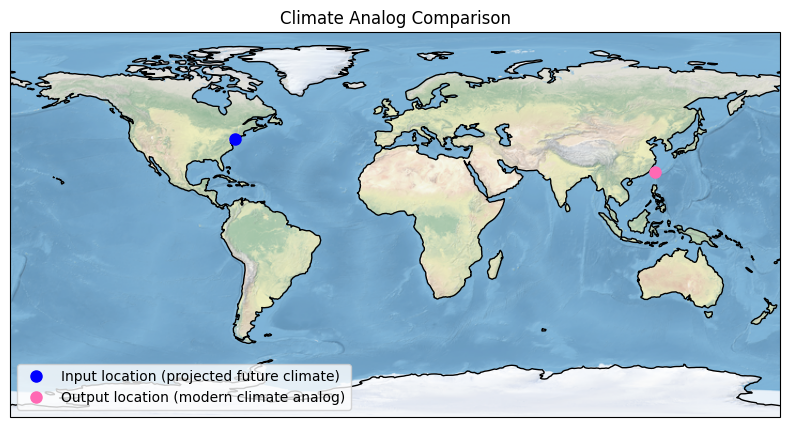

(np.float64(24.5), np.float64(121.75))

In [25]:
find_climate_analog(mod_data_norm, fut_data_norm, mod_data_raw, fut_data_raw, mod_lats, mod_lons, fut_lats, fut_lons)

In [22]:
def show_extreme_values(mod_data_raw, fut_data_raw, mod_lats, mod_lons, fut_lats, fut_lons):
    '''
    Displays min/max values (modern & future) and their locations for a selected variable.
    Handles NaNs gracefully.
    '''
    try:
        variable = input("Enter a variable name (choose one: ps, snow, clouds, temps, spechum, wind, precip): ").strip()

        if variable not in mod_data_raw or variable not in fut_data_raw:
            print(f"Variable '{variable}' not found in data.")
            return

        # Get pretty name and units
        var_name_pretty = pretty_var_names.get(variable, variable.capitalize())
        var_units = var_units_dict.get(variable, '')

        # Extract arrays
        mod_data = mod_data_raw[variable].values
        fut_data = fut_data_raw[variable].values

        # Modern values
        mod_min_value = np.nanmin(mod_data)
        mod_max_value = np.nanmax(mod_data)
        mod_min_idx = np.unravel_index(np.nanargmin(mod_data), mod_data.shape)
        mod_max_idx = np.unravel_index(np.nanargmax(mod_data), mod_data.shape)
        mod_min_lat, mod_min_lon = mod_lats[mod_min_idx[0]], mod_lons[mod_min_idx[1]]
        mod_max_lat, mod_max_lon = mod_lats[mod_max_idx[0]], mod_lons[mod_max_idx[1]]

        # Future values
        if np.all(np.isnan(fut_data)):
            fut_min_value = fut_max_value = np.nan
            fut_min_lat = fut_min_lon = fut_max_lat = fut_max_lon = None
        else:
            fut_min_value = np.nanmin(fut_data)
            fut_max_value = np.nanmax(fut_data)
            fut_min_idx = np.unravel_index(np.nanargmin(fut_data), fut_data.shape)
            fut_max_idx = np.unravel_index(np.nanargmax(fut_data), fut_data.shape)
            fut_min_lat, fut_min_lon = fut_lats[fut_min_idx[0]], fut_lons[fut_min_idx[1]]
            fut_max_lat, fut_max_lon = fut_lats[fut_max_idx[0]], fut_lons[fut_max_idx[1]]

        # Create summary table
        data = {
            'Modern Mean Annual': [f"{mod_min_value:.2f}", f"{mod_max_value:.2f}"],
            'Future Mean Annual': [
                f"{fut_min_value:.2f}" if not np.isnan(fut_min_value) else "N/A",
                f"{fut_max_value:.2f}" if not np.isnan(fut_max_value) else "N/A"
            ]
        }
        df = pd.DataFrame(data, index=['Min', 'Max'])

        print(f"Extreme Values for {var_name_pretty} ({var_units}):")
        print(df)

        print(f"  Modern Data Extremes:")
        print(f"Min: Latitude {mod_min_lat:.2f}°, Longitude {mod_min_lon:.2f}° (Value: {mod_min_value:.2f} {var_units})")
        print(f"Max: Latitude {mod_max_lat:.2f}°, Longitude {mod_max_lon:.2f}° (Value: {mod_max_value:.2f} {var_units})")

        print(f"  Future Data Extremes:")
        if fut_min_lat is not None and fut_max_lat is not None:
            print(f"Min: Latitude {fut_min_lat:.2f}°, Longitude {fut_min_lon:.2f}° (Value: {fut_min_value:.2f} {var_units})")
            print(f"Max: Latitude {fut_max_lat:.2f}°, Longitude {fut_max_lon:.2f}° (Value: {fut_max_value:.2f} {var_units})")
        else:
            print("No valid (non-NaN) values found in future data.")

    except Exception as e:
        print(f"Error: {e}")

In [31]:
show_extreme_values(mod_data_raw, fut_data_raw, mod_lats, mod_lons, fut_lats, fut_lons)

Enter a variable name (choose one: ps, snow, clouds, temps, spechum, wind, precip):  temps


Extreme Values for Temperature (°C):
    Modern Mean Annual Future Mean Annual
Min             -53.09             -45.01
Max              34.56              38.04
  Modern Data Extremes:
Min: Latitude -79.75°, Longitude 90.50° (Value: -53.09 °C)
Max: Latitude 13.50°, Longitude 40.75° (Value: 34.56 °C)
  Future Data Extremes:
Min: Latitude -79.63°, Longitude 90.00° (Value: -45.01 °C)
Max: Latitude 14.61°, Longitude 347.50° (Value: 38.04 °C)
